In [22]:
# Paso 1: Importación de bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler,label_binarize
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import kendalltau, pointbiserialr

# Integración de Weka (segura)
try:
    import weka.core.jvm as jvm
    from weka.core.converters import Loader
    from weka.classifiers import Classifier, Evaluation
    from weka.core.classes import Random
    weka_available = True
except:
    weka_available = False

# Integración de R (segura)
"""
try:
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    r_available = True
except:
    r_available = False
"""

'\ntry:\n    import rpy2.robjects as ro\n    from rpy2.robjects import pandas2ri\n    pandas2ri.activate()\n    r_available = True\nexcept:\n    r_available = False\n'

In [23]:
# Paso 1: Cargar el dataset
file_path = "faults-10.csv"
df = pd.read_csv(file_path)

In [24]:
# Paso 2: Crear variable 'target' a partir de las columnas one-hot de clase
class_columns = df.columns[-7:]

def obtener_clase_activa(row):
    for col in class_columns:
        if row[col] == 1:
            return str(col)
    return None

df["target"] = df.apply(obtener_clase_activa, axis=1)
df = df.drop(columns=class_columns)

# Paso 3: Separar variables y target
X = df.drop(columns=["target"])
y = df["target"]

# Paso 4: Dividir en entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

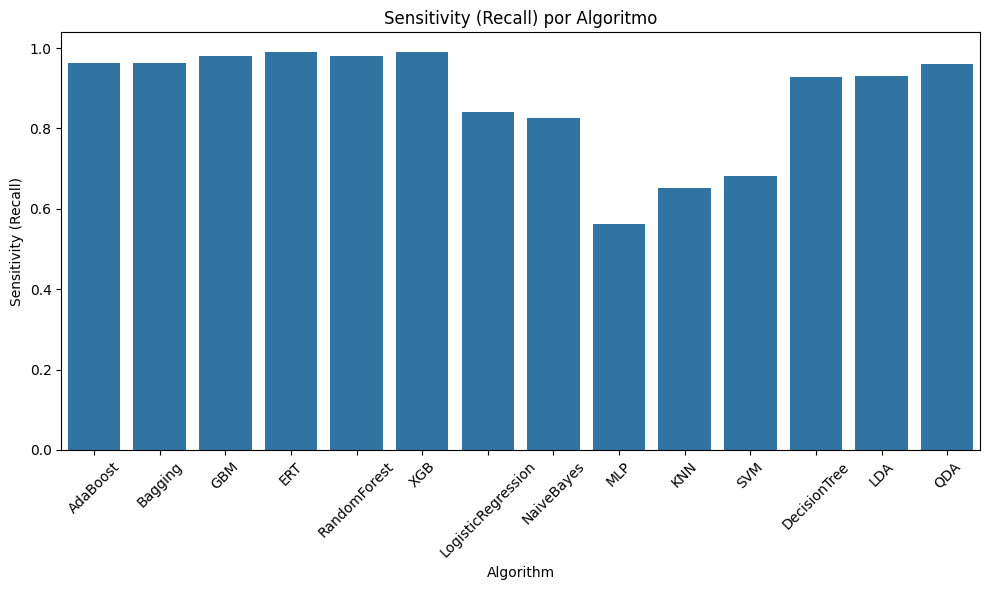

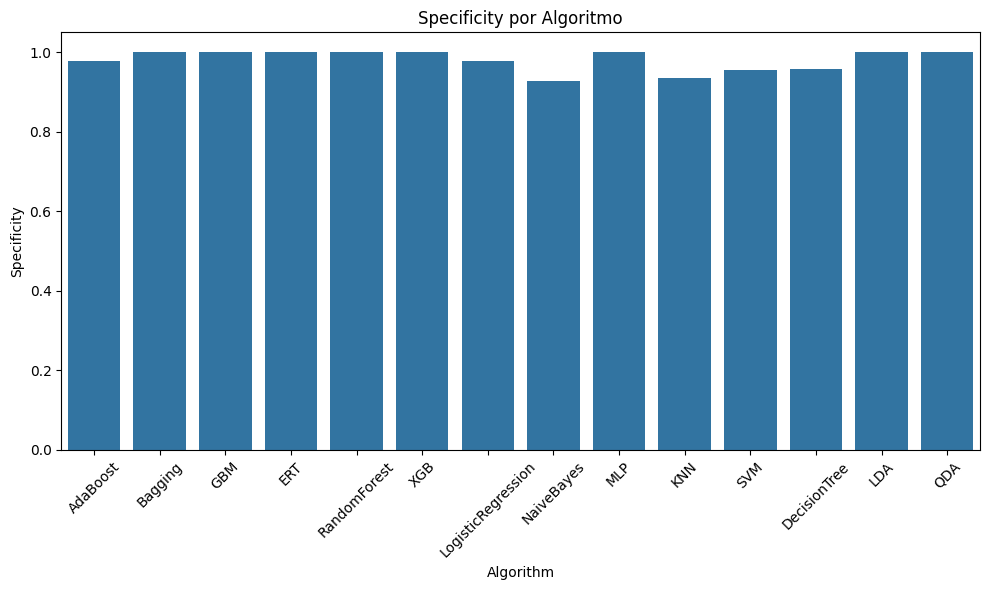

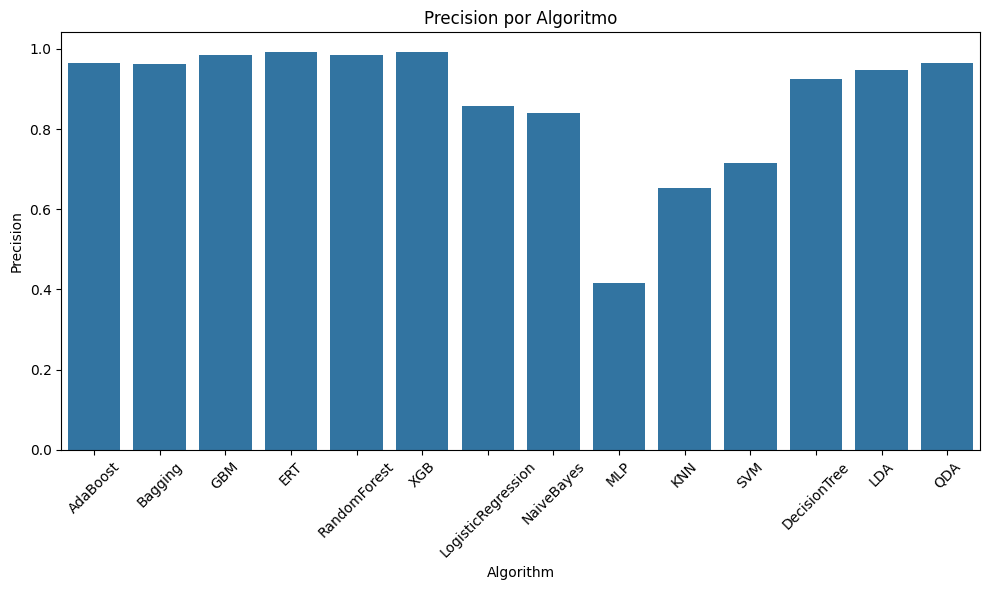

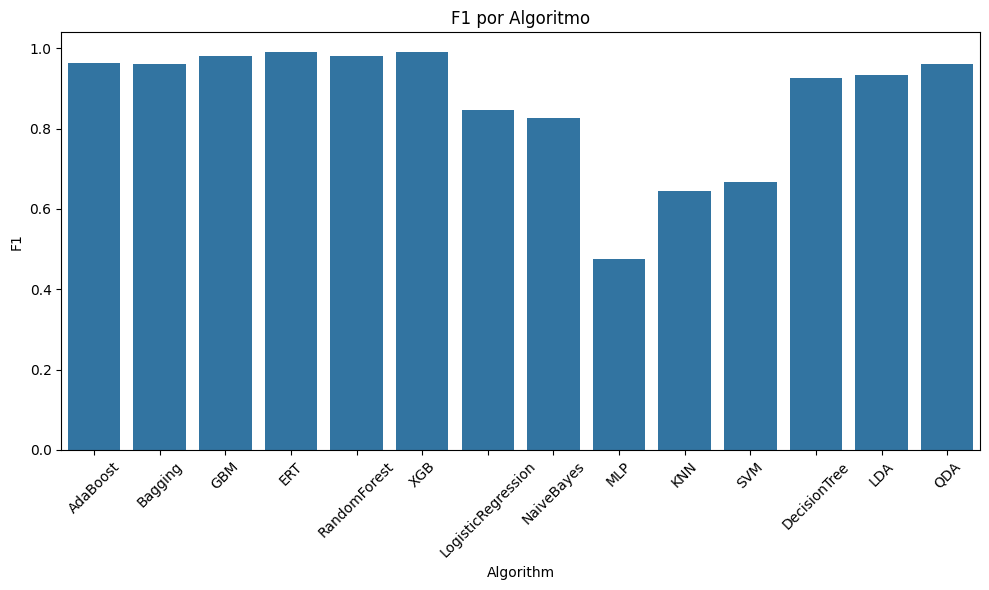

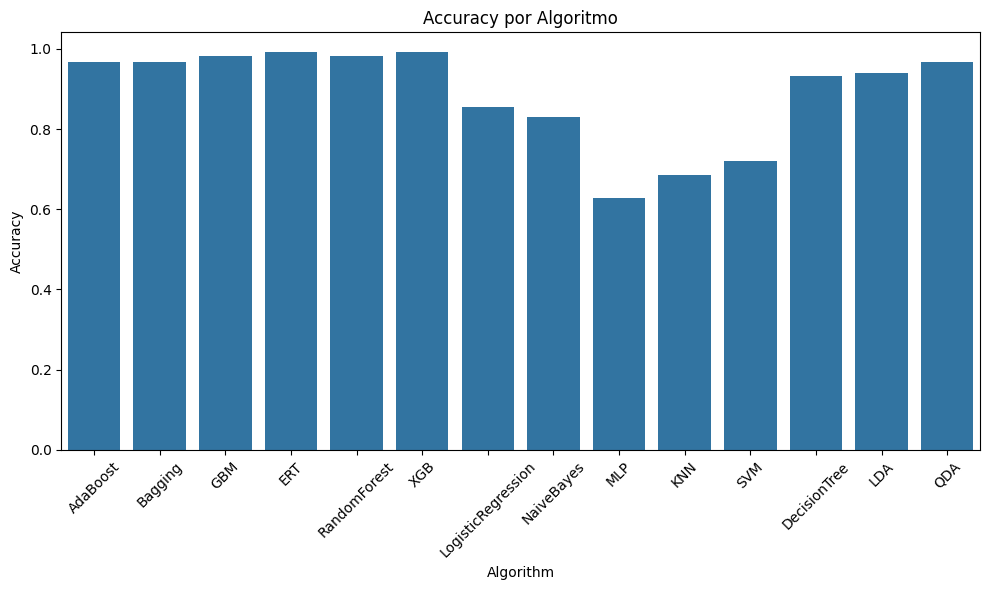

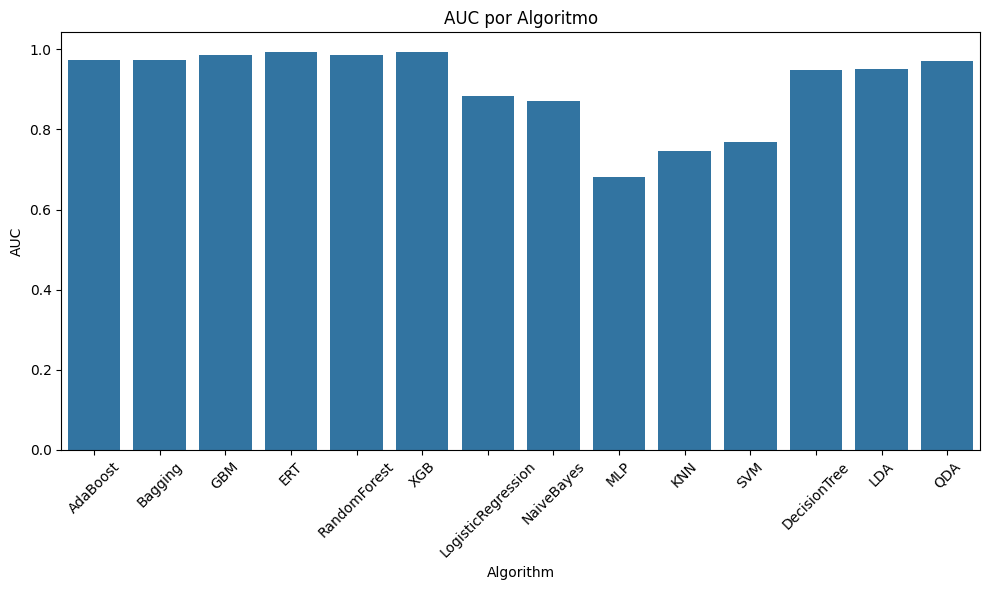

In [25]:
# Convertir etiquetas de clase (strings) a enteros
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)

# Paso 4: Métricas ajustadas a multiclase
def metricas(model_label, y_true, y_pred):
    cm = confusion_matrix(y_valid, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    
    try:
        specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    except:
        specificity = np.nan

   
    try:
        y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
        y_pred_bin = label_binarize(y_pred, classes=np.unique(y_true))
        auc = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovo')
    except:
        auc = np.nan

    return {
        'Algorithm': model_label,
        'Sensitivity (Recall)': recall,
        'Specificity': specificity,
        'Precision': precision,
        'F1': f1,
        'Accuracy': accuracy,
        'AUC':auc
    }


# Paso 5: Modelos
models = {
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'GBM': GradientBoostingClassifier(),
    'ERT': ExtraTreesClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}

# Entrenar modelos

X_train_np = np.ascontiguousarray(X_train.values)
X_valid_np = np.ascontiguousarray(X_valid.values)

results = []

for model_label, model in models.items():
    model.fit(X_train_np, y_train_enc)
    y_pred = model.predict(X_valid_np)
    y_pred_decoded = le.inverse_transform(y_pred)
    result = metricas(model_label, y_valid, y_pred_decoded)
    results.append(result)

df_results = pd.DataFrame(results)

# Paso 6: Visualización de métricas
metrics = ['Sensitivity (Recall)','Specificity', 'Precision', 'F1', 'Accuracy','AUC']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Algorithm', y=metric, data=df_results)
    plt.title(f'{metric} por Algoritmo')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

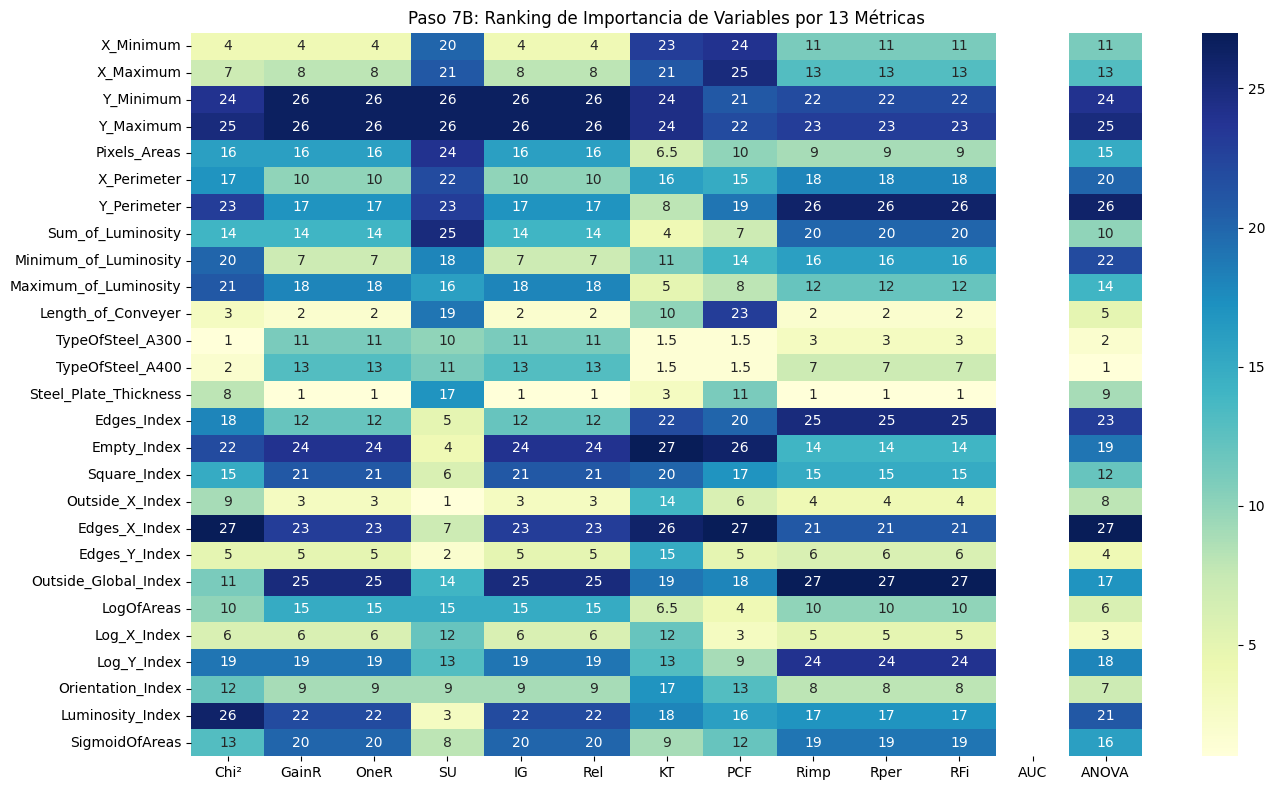

                       Chi²  GainR  OneR    SU    IG   Rel    KT   PCF  Rimp  \
Steel_Plate_Thickness   8.0    1.0   1.0  17.0   1.0   1.0   3.0  11.0   1.0   
Outside_X_Index         9.0    3.0   3.0   1.0   3.0   3.0  14.0   6.0   4.0   
Edges_Y_Index           5.0    5.0   5.0   2.0   5.0   5.0  15.0   5.0   6.0   
TypeOfSteel_A300        1.0   11.0  11.0  10.0  11.0  11.0   1.5   1.5   3.0   
Length_of_Conveyer      3.0    2.0   2.0  19.0   2.0   2.0  10.0  23.0   2.0   
Log_X_Index             6.0    6.0   6.0  12.0   6.0   6.0  12.0   3.0   5.0   
TypeOfSteel_A400        2.0   13.0  13.0  11.0  13.0  13.0   1.5   1.5   7.0   
Orientation_Index      12.0    9.0   9.0   9.0   9.0   9.0  17.0  13.0   8.0   
X_Minimum               4.0    4.0   4.0  20.0   4.0   4.0  23.0  24.0  11.0   
LogOfAreas             10.0   15.0  15.0  15.0  15.0  15.0   6.5   4.0  10.0   
X_Maximum               7.0    8.0   8.0  21.0   8.0   8.0  21.0  25.0  13.0   
Minimum_of_Luminosity  20.0    7.0   7.0

In [26]:
# Paso 7: Importancia de características (multiclase con codificación y escalado para chi2)

# Copiamos desde el dataset de trabajo y codificamos target
df_importancia = df.copy()  # usa tu dataset preprocesado con 'target'
le_imp = LabelEncoder()
df_importancia['target'] = le_imp.fit_transform(df_importancia['target'])

# Variables predictoras
X_imp = df_importancia.drop('target', axis=1).astype('float64')
y_imp = df_importancia['target']

# Escalar solo para chi²
scaler = MinMaxScaler()
X_imp_scaled = pd.DataFrame(scaler.fit_transform(X_imp), columns=X_imp.columns)

# Métricas base
chi2_vals, _ = chi2(X_imp_scaled, y_imp)
mi_vals = mutual_info_classif(X_imp, y_imp, random_state=42)
anova_vals, _ = f_classif(X_imp, y_imp)

# Random Forest Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_imp, y_imp)
rfi_vals = rf.feature_importances_

# AUC por variable (multiclase: one-vs-one)
auc_vals = []
for col in X_imp.columns:
    try:
        auc_val = roc_auc_score(y_imp, X_imp[col], multi_class='ovo')
    except:
        auc_val = np.nan
    auc_vals.append(auc_val)

# Kendall Tau
kt_vals = [abs(kendalltau(X_imp[col], y_imp).correlation) for col in X_imp.columns]

# PCF (punto biserial)
pcf_vals = [abs(pointbiserialr(X_imp[col], y_imp)[0]) for col in X_imp.columns]

# Aproximaciones para GainR, OneR, SU, Rel, Rimp, Rper
gainr_vals = mi_vals
oner_vals = mi_vals
su_vals = mi_vals / (X_imp.var().values + 1e-6)
rel_vals = mi_vals
rimp_vals = rfi_vals
rper_vals = rfi_vals

# Compilar en DataFrame
importancia_df = pd.DataFrame({
    'Chi²': chi2_vals,
    'GainR': gainr_vals,
    'OneR': oner_vals,
    'SU': su_vals,
    'IG': mi_vals,
    'Rel': rel_vals,
    'KT': kt_vals,
    'PCF': pcf_vals,
    'Rimp': rimp_vals,
    'Rper': rper_vals,
    'RFi': rfi_vals,
    'AUC': auc_vals,
    'ANOVA': anova_vals
}, index=X_imp.columns)

# Paso 7B: Ranking final
ranking_df = importancia_df.rank(ascending=False)
ranking_df['Mean'] = ranking_df.mean(axis=1)
ranking_df['Rank'] = ranking_df['Mean'].rank()

# Visualización del ranking
plt.figure(figsize=(14, 8))
sns.heatmap(ranking_df.iloc[:, :-2], annot=True, cmap='YlGnBu')
plt.title("Paso 7B: Ranking de Importancia de Variables por 13 Métricas")
plt.tight_layout()
plt.show()

# Mostrar ranking ordenado
print(ranking_df.sort_values("Rank"))


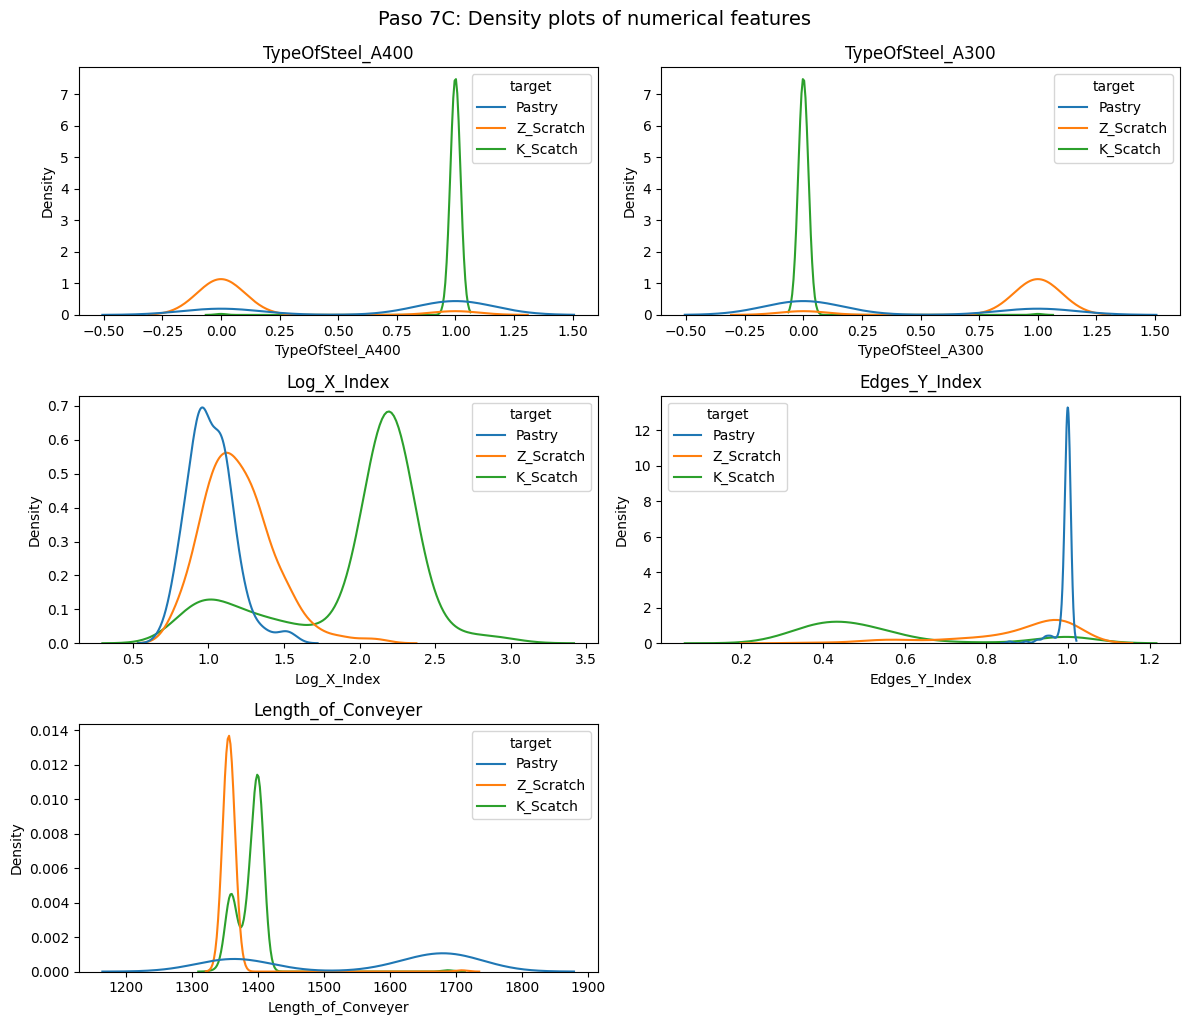

In [27]:
# Paso 7C: Gráficos de densidad de variables numéricas por clase

numerical_features = ['TypeOfSteel_A400', 'TypeOfSteel_A300', 'Log_X_Index', 'Edges_Y_Index', 'Length_of_Conveyer']

plt.figure(figsize=(12, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=df, x=col, hue='target', fill=False)
    plt.title(col)

plt.tight_layout()
plt.suptitle("Paso 7C: Density plots of numerical features", fontsize=14, y=1.02)
plt.show()


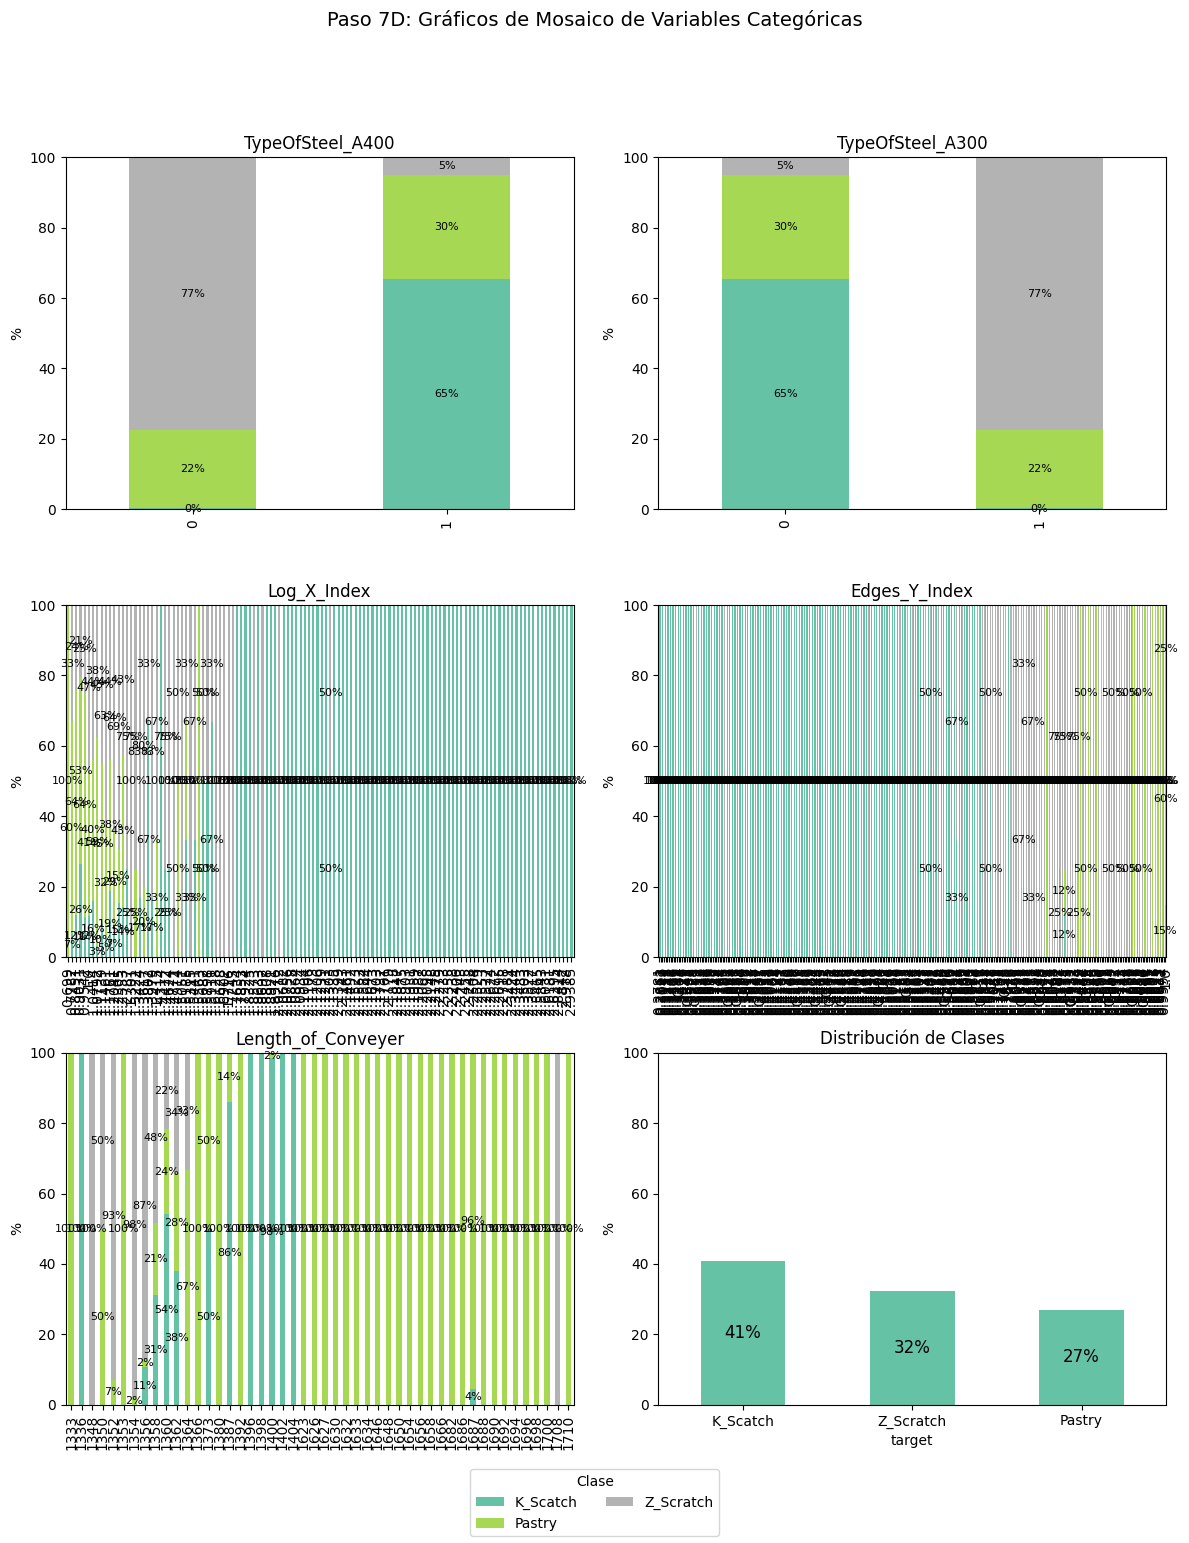

In [28]:
# Paso 7D: Gráficos de mosaico para variables categóricas (adaptado a faults-10.csv)

# Suponiendo que df ya contiene la columna 'target'
# Y que estas son las variables categóricas representativas
categorical_columns_mosaic = ['TypeOfSteel_A400', 'TypeOfSteel_A300', 'Log_X_Index', 'Edges_Y_Index', 'Length_of_Conveyer','target']
df_mosaic = df.copy()

# Asegurar que estén como categóricas
df_mosaic[categorical_columns_mosaic] = df_mosaic[categorical_columns_mosaic].astype('category')

# Graficar
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
axes = axes.flatten()

for i, col in enumerate(categorical_columns_mosaic):
    ax = axes[i]
    if col != 'target':
        prop_df = pd.crosstab(df_mosaic[col], df_mosaic['target'], normalize='index') * 100
        prop_df.plot(kind='bar', stacked=True, ax=ax, colormap='Set2', legend=False)
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2.,
                        f'{height:.0f}%', ha="center", va="center", color='black', fontsize=8)
        ax.set_title(col)
        ax.set_ylabel('%')
        ax.set_xlabel('')
        ax.set_ylim(0, 100)
    else:
        class_counts = df_mosaic['target'].value_counts(normalize=True) * 100
        class_counts.plot(kind='bar', ax=ax, colormap='Set2')
        for j, v in enumerate(class_counts):
            ax.text(j, v / 2, f'{v:.0f}%', ha='center', va='center', color='black', fontsize=12)
        ax.set_title("Distribución de Clases")
        ax.set_ylabel('%')
        ax.set_xticklabels(class_counts.index, rotation=0)
        ax.set_ylim(0, 100)

# Quitar ejes vacíos si hay menos subgráficos
for j in range(len(categorical_columns_mosaic), len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Clase", loc='lower center', ncol=2)
plt.suptitle('Paso 7D: Gráficos de Mosaico de Variables Categóricas', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()


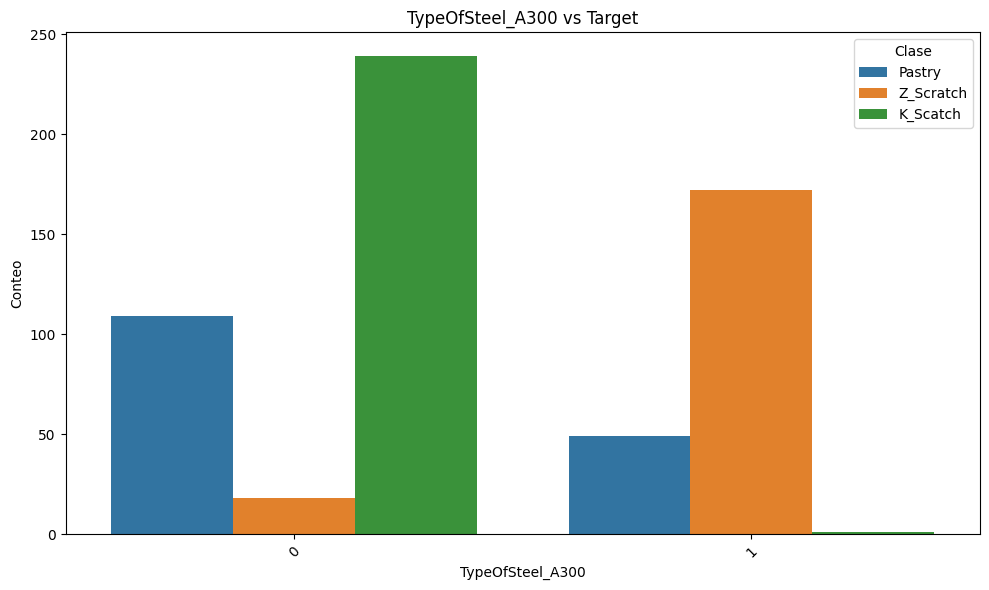

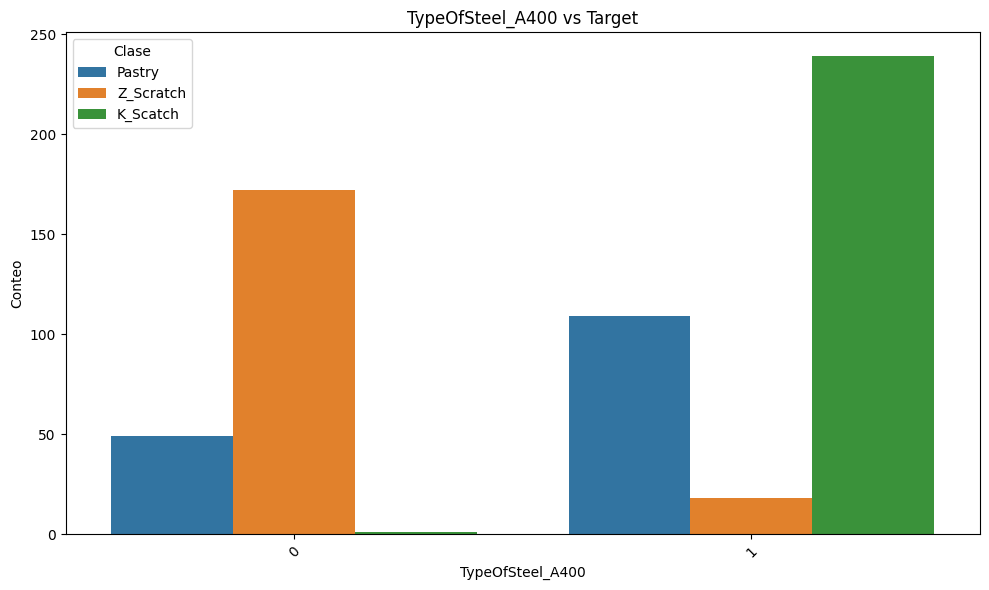

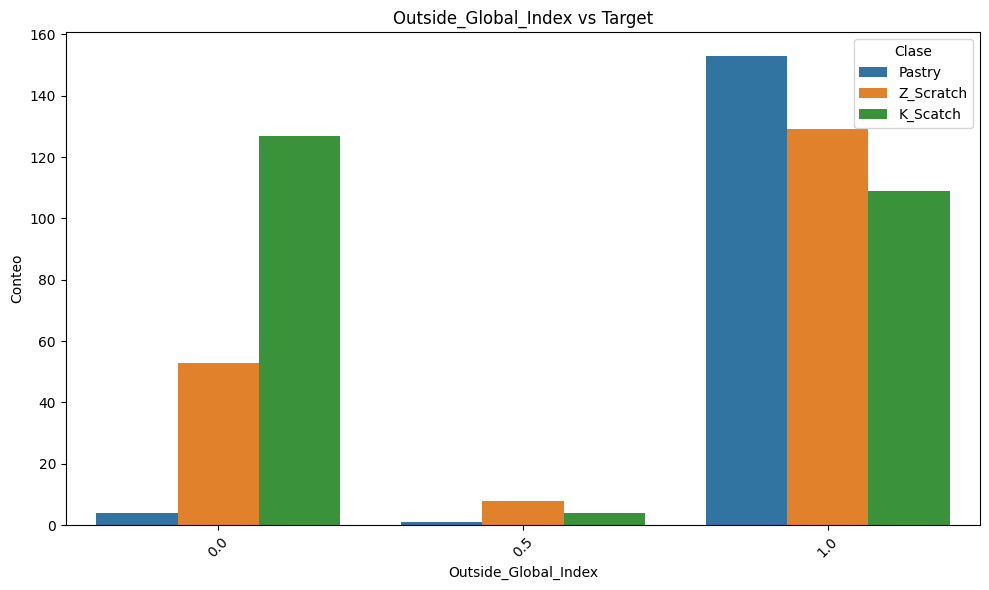

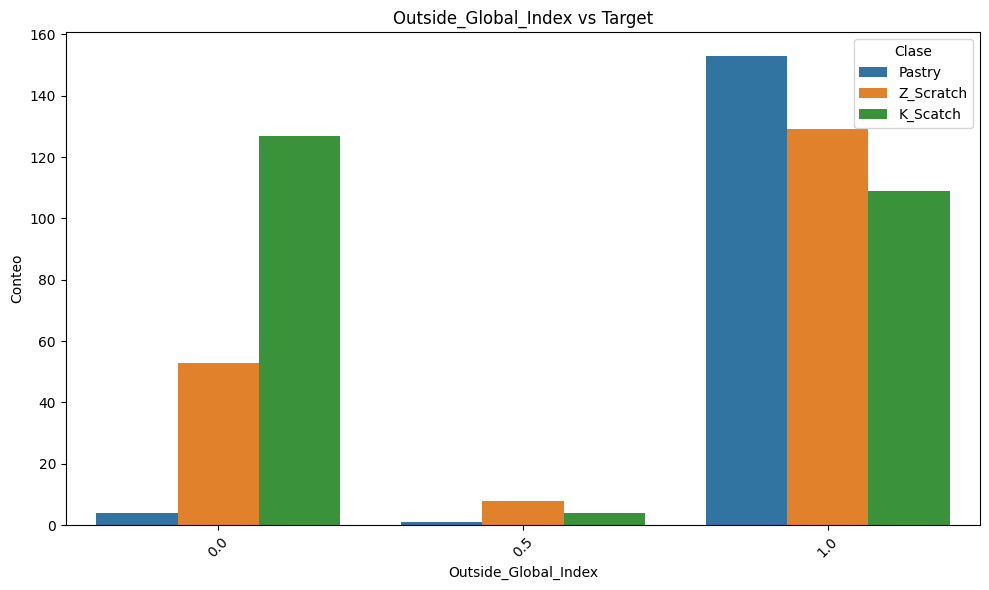

In [29]:
# Paso 8: Gráficos de conteo de variables categóricas vs target

# Convertir target a string
df['target'] = df['target'].astype(str)

# Definir variables categóricas a analizar
categorical_columns = ['TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index', 'Outside_Global_Index']

# Graficar conteos por clase
for col in categorical_columns:
    if col != 'target':
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='target', data=df)
        plt.title(f'{col} vs Target')
        plt.xlabel(col)
        plt.ylabel('Conteo')
        plt.xticks(rotation=45)
        plt.legend(title='Clase')
        plt.tight_layout()
        plt.show()


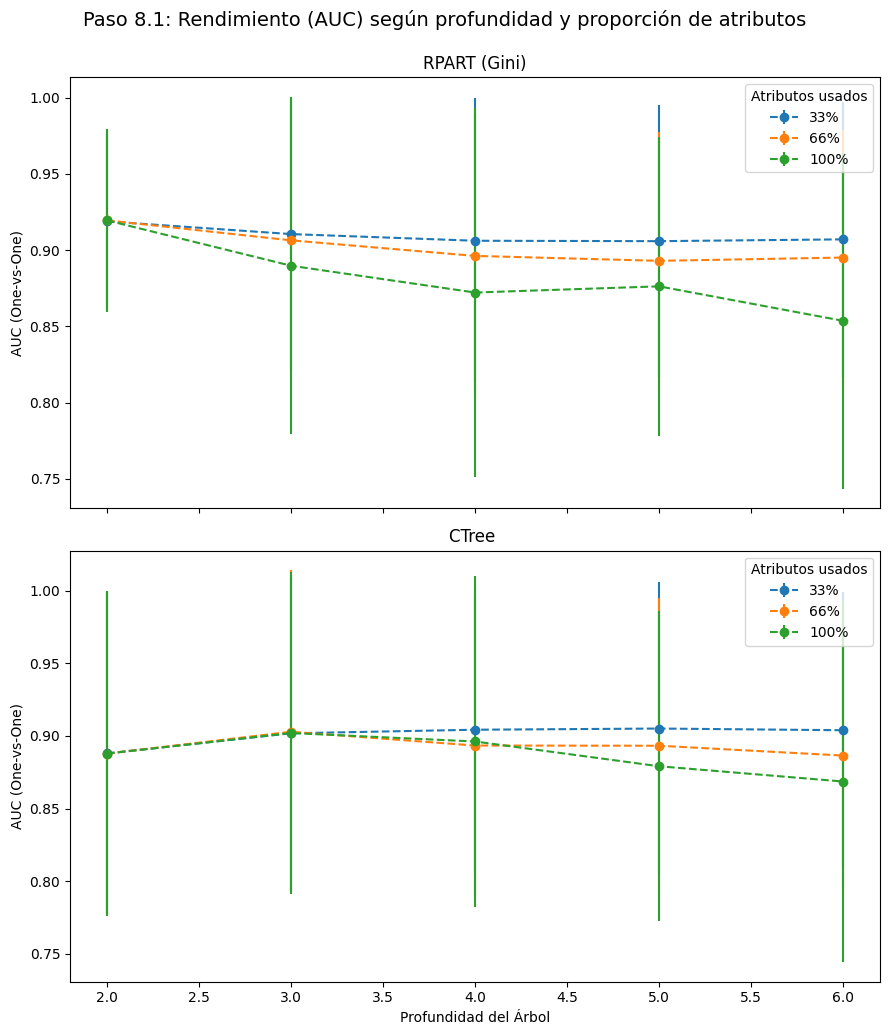

In [30]:
#paso 8.1: rendimiento (AUC) con profundidad y porcentaje de atributos
# Subconjuntos definidos
# Paso 8.1: Rendimiento (AUC multiclase) con diferentes profundidades y proporciones de atributos

# Preparar el dataset
df_encoded = df.copy()
le_auc = LabelEncoder()
df_encoded["target"] = le_auc.fit_transform(df_encoded["target"])

# Subconjuntos de atributos según ranking
top_5 = ranking_df.sort_values("Rank").head(5).index.tolist()
top_10 = ranking_df.sort_values("Rank").head(10).index.tolist()
all_vars = df_encoded.columns.drop("target").tolist()

attribute_sets = {
    '33%': top_5,
    '66%': top_10,
    '100%': all_vars
}

depths = [2, 3, 4, 5, 6]
results_rpart = []
results_ctree = []

for name, feature_list in attribute_sets.items():
    X = df_encoded[feature_list].astype('float64')
    y = df_encoded['target']

    for depth in depths:
        # RPART - criterio Gini
        rpart = DecisionTreeClassifier(max_depth=depth, criterion='gini', random_state=42)
        rpart_scores = cross_val_score(rpart, X, y, cv=5, scoring='roc_auc_ovo')
        results_rpart.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(rpart_scores),
            'Std': np.std(rpart_scores)
        })

        # CTREE - criterio Entropía
        ctree = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
        ctree_scores = cross_val_score(ctree, X, y, cv=5, scoring='roc_auc_ovo')
        results_ctree.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(ctree_scores),
            'Std': np.std(ctree_scores)
        })

# Convertir resultados a DataFrame
rpart_df = pd.DataFrame(results_rpart)
ctree_df = pd.DataFrame(results_ctree)

# Gráfico de AUC por profundidad
fig, axes = plt.subplots(2, 1, figsize=(9, 10), sharex=True)

for subset in rpart_df['Subset'].unique():
    data = rpart_df[rpart_df['Subset'] == subset]
    axes[0].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[0].set_title("RPART (Gini)")
axes[0].set_ylabel("AUC (One-vs-One)")
axes[0].legend(title="Atributos usados")

for subset in ctree_df['Subset'].unique():
    data = ctree_df[ctree_df['Subset'] == subset]
    axes[1].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[1].set_title("CTree ")
axes[1].set_xlabel("Profundidad del Árbol")
axes[1].set_ylabel("AUC (One-vs-One)")
axes[1].legend(title="Atributos usados")

plt.tight_layout()
plt.suptitle("Paso 8.1: Rendimiento (AUC) según profundidad y proporción de atributos", fontsize=14, y=1.03)
plt.show()


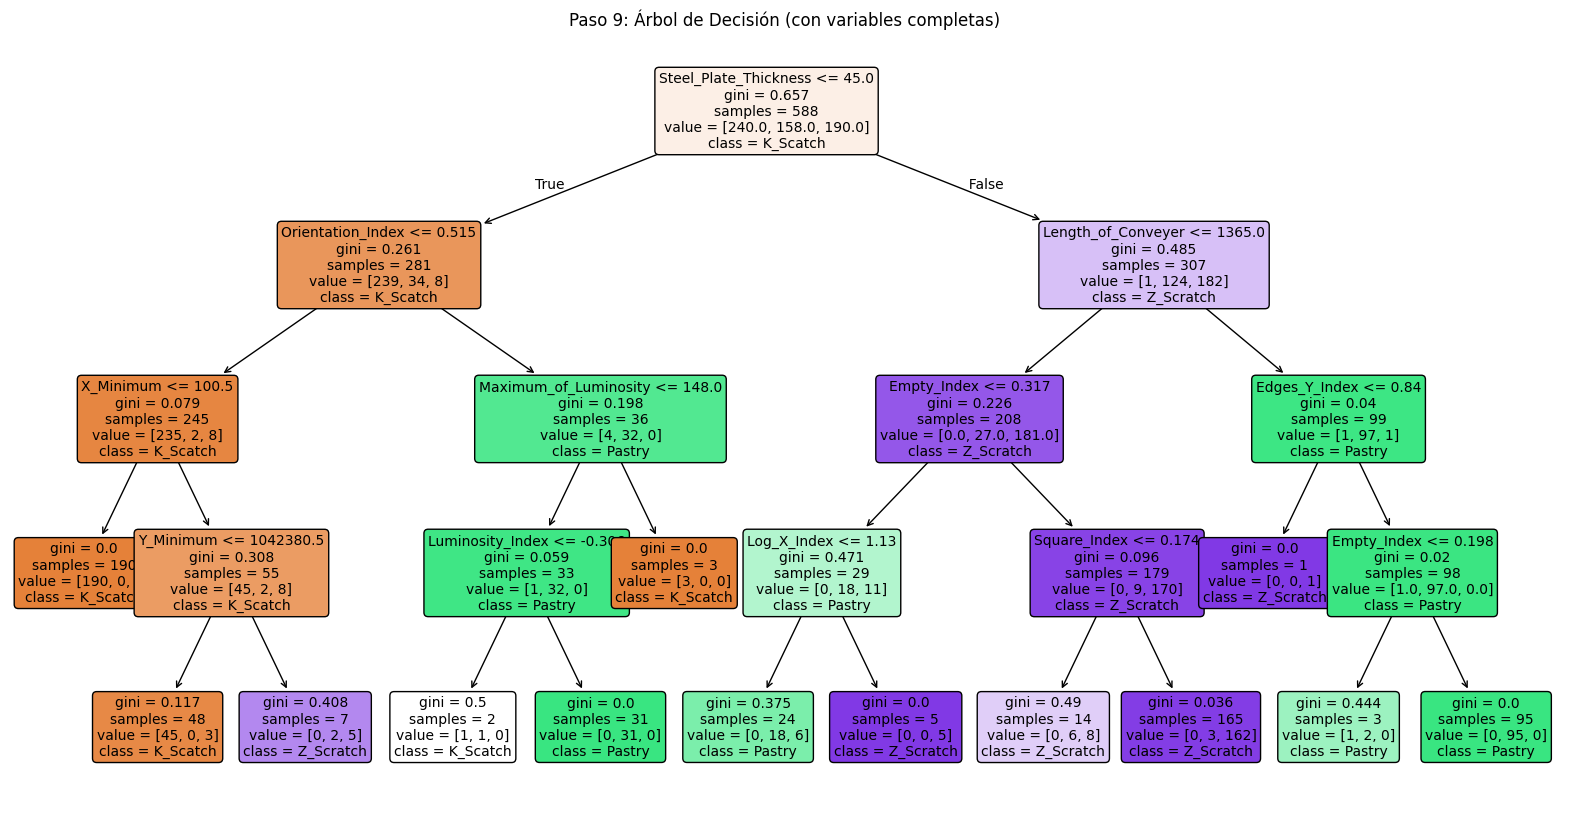

In [31]:
# Paso 9: Árbol de decisión con todas las variables

# Asegurarnos de tener variables codificadas
X_tree = df_encoded.drop(columns=["target"])
y_tree = df_encoded["target"]

# Entrenar árbol completo
dt = DecisionTreeClassifier(max_depth=4, random_state=42)  # puedes ajustar max_depth si deseas
dt.fit(X_tree, y_tree)

# Visualizar el árbol
plt.figure(figsize=(20, 10))
plot_tree(
    dt,
    filled=True,
    feature_names=list(X_tree.columns),
    class_names=le_auc.classes_,  # etiquetas originales
    rounded=True,
    fontsize=10
)
plt.title("Paso 9: Árbol de Decisión (con variables completas)")
plt.show()

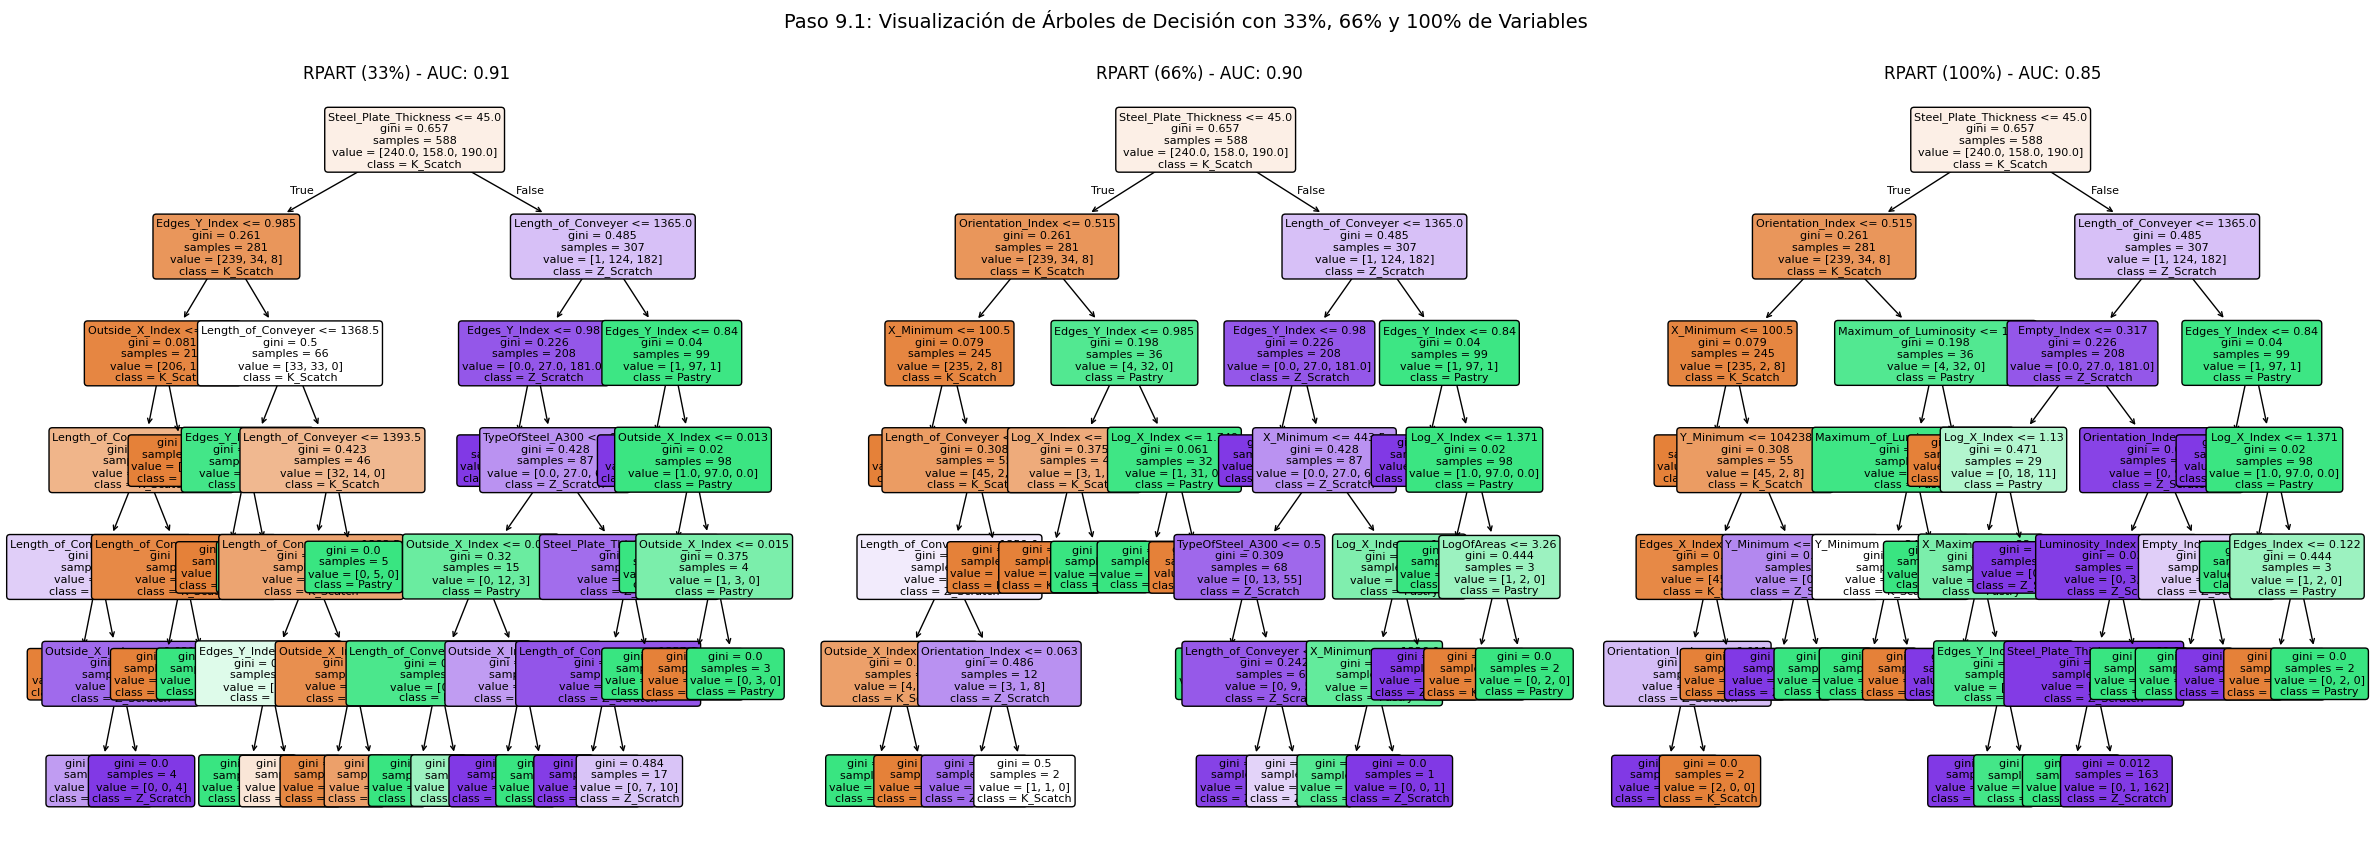

In [32]:
# Paso 9.1: Visualización de RPART con 33%, 66% y 100% de características (max_depth=6)

# Asegurarse de tener datos codificados
X_all = df_encoded.drop(columns=["target"])
y_all = df_encoded["target"]

# Crear subconjuntos según ranking
top_5 = ranking_df.sort_values("Rank").head(5).index.tolist()
top_10 = ranking_df.sort_values("Rank").head(10).index.tolist()
all_features = df_encoded.columns.drop("target").tolist()

attribute_sets = {
    '33%': top_5,
    '66%': top_10,
    '100%': all_features
}

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
rpart_auc_scores = {}

for ax, (name, features) in zip(axes, attribute_sets.items()):
    X = df_encoded[features].astype('float64')
    y = df_encoded['target']

    model = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
    model.fit(X, y)

    auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc_ovo').mean()
    rpart_auc_scores[name] = auc

    plot_tree(
        model,
        feature_names=list(X.columns),
        class_names=le_auc.classes_,
        filled=True,
        rounded=True,
        fontsize=8,
        ax=ax
    )
    ax.set_title(f"RPART ({name}) - AUC: {auc:.2f}")

plt.tight_layout()
plt.suptitle("Paso 9.1: Visualización de Árboles de Decisión con 33%, 66% y 100% de Variables", fontsize=14, y=1.05)
plt.show()



In [33]:
from sklearn.tree import export_graphviz
import graphviz

# Paso 9.2: Exportación de árbol con 33% de variables usando Graphviz

# Usar top 5 variables del ranking como 33%
top_5 = ranking_df.sort_values("Rank").head(5).index.tolist()
X_33 = df_encoded[top_5].astype('float64')
y_33 = df_encoded['target']

# Entrenar modelo
model_33 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_33.fit(X_33, y_33)

# Exportar a formato .dot y visualizar
dot_data_33 = export_graphviz(
    model_33,
    out_file=None,
    feature_names=X_33.columns,
    class_names=le_auc.classes_,
    filled=True,
    rounded=True,
    special_characters=True
)

graph_33 = graphviz.Source(dot_data_33)
graph_33.render("tree_33", format="png", cleanup=False)  # Exportar como PNG
graph_33.view()  # Abrir en visor por defecto

'tree_33.pdf'

In [34]:
# 66%
# Paso 9.3: Exportación de árbol con 66% de variables usando Graphviz

# Usar top 10 variables del ranking como 66%
top_10 = ranking_df.sort_values("Rank").head(10).index.tolist()
X_66 = df_encoded[top_10].astype('float64')
y_66 = df_encoded['target']

# Entrenar modelo
model_66 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_66.fit(X_66, y_66)

# Exportar a formato .dot y generar imagen
dot_data_66 = export_graphviz(
    model_66,
    out_file=None,
    feature_names=X_66.columns,
    class_names=le_auc.classes_,  # clases originales del LabelEncoder
    filled=True,
    rounded=True,
    special_characters=True
)

graph_66 = graphviz.Source(dot_data_66)
graph_66.render("tree_66", format="png", cleanup=False)  # Exportar como PNG
graph_66.view()  # Mostrar en visor

'tree_66.pdf'

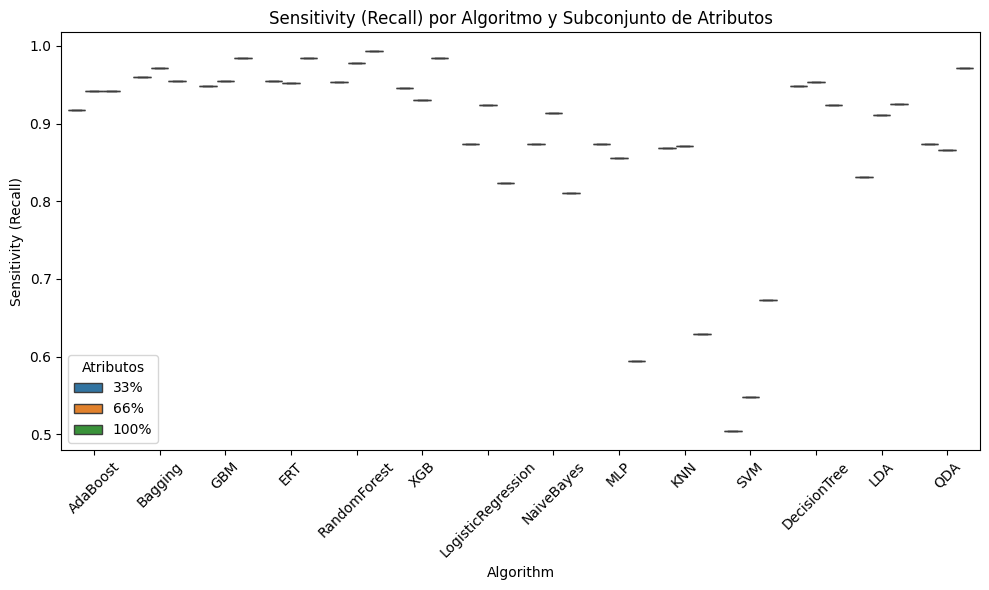

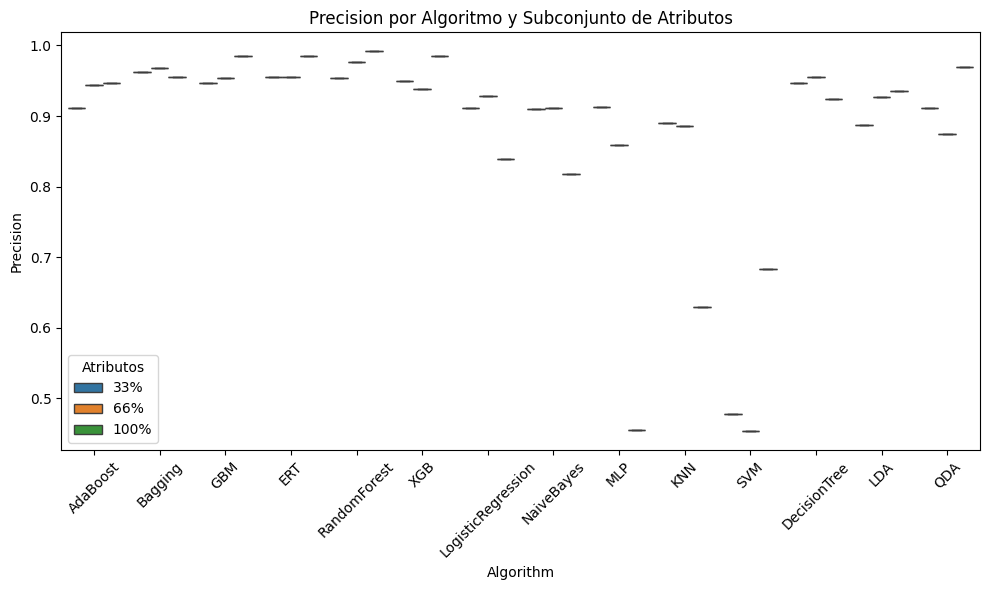

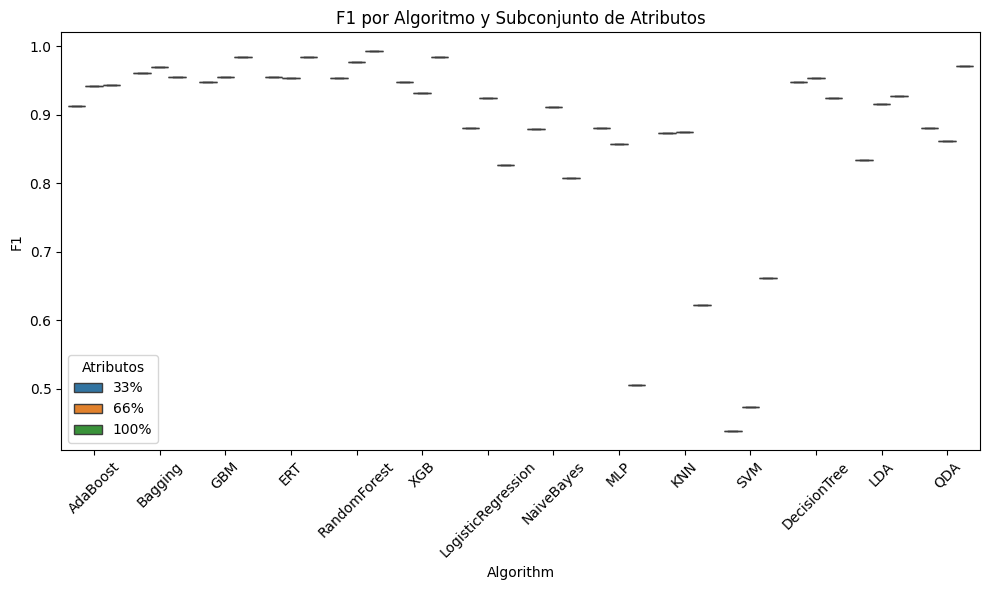

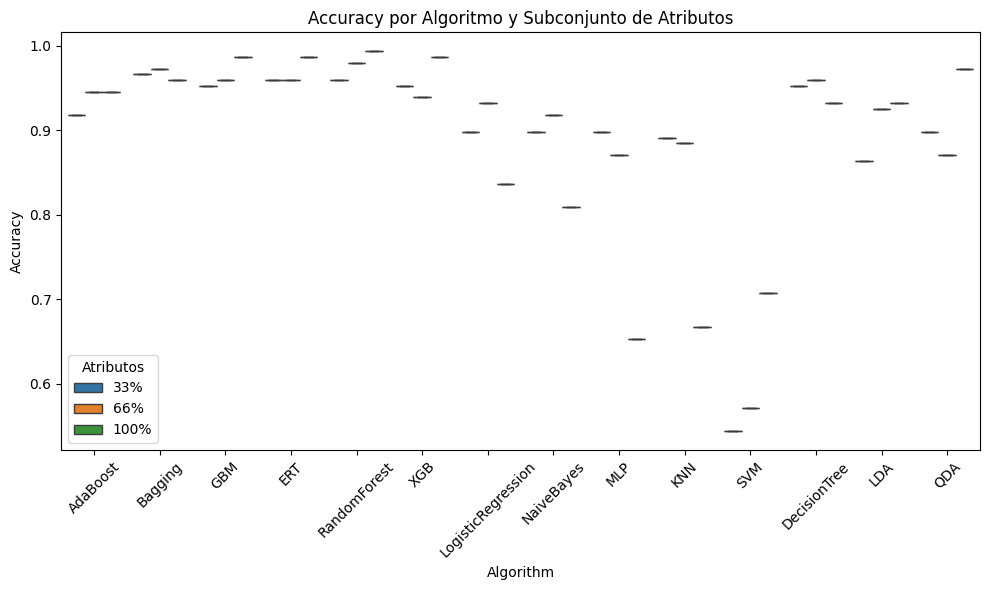

In [35]:
# Paso 10: Evaluación de modelos con 33%, 66% y 100% de variables

# Definir subconjuntos basados en el ranking
top_5 = ranking_df.sort_values("Rank").head(5).index.tolist()
top_10 = ranking_df.sort_values("Rank").head(10).index.tolist()
all_features = df_encoded.columns.drop("target").tolist()

datasets = {
    '33%': df_encoded[top_5 + ['target']],
    '66%': df_encoded[top_10 + ['target']],
    '100%': df_encoded[all_features + ['target']]
}

results_all = []

for name, dataset in datasets.items():
    X = dataset.drop('target', axis=1).astype('float64')
    y = dataset['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    X_train_np = np.ascontiguousarray(X_train.values)
    X_valid_np = np.ascontiguousarray(X_valid.values)

    for model_label, model in models.items():
        model.fit(X_train_np, y_train)
        y_pred = model.predict(X_valid_np)
        result = metricas(model_label, y_valid, y_pred)  # función ya adaptada a multiclase
        result['Atributos'] = name
        results_all.append(result)

df_results_all = pd.DataFrame(results_all)

# Visualización de métricas
for metric in ['Sensitivity (Recall)', 'Precision', 'F1', 'Accuracy']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Algorithm', y=metric, hue='Atributos', data=df_results_all)
    plt.title(f'{metric} por Algoritmo y Subconjunto de Atributos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

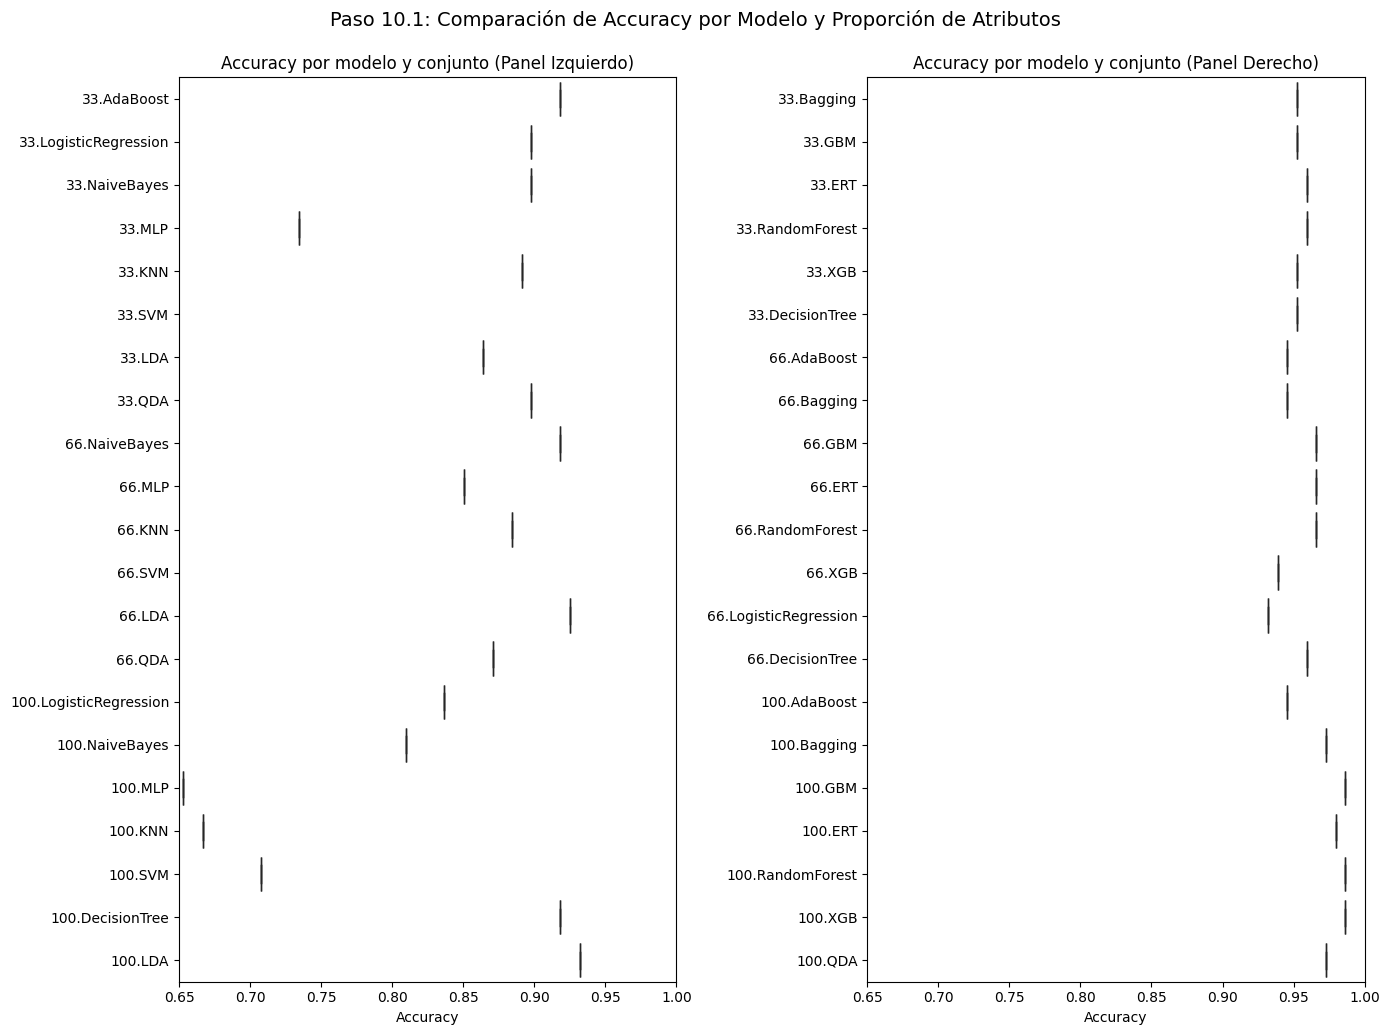

In [36]:
# Paso 10.1: Evaluación con conjuntos de datos distintos y visualización de Accuracy tipo boxplot
# Gráfico tipo panel como la imagen de referencia
import matplotlib.gridspec as gridspec
# Subconjuntos de atributos
top_5 = ranking_df.sort_values("Rank").head(5).index.tolist()
top_10 = ranking_df.sort_values("Rank").head(10).index.tolist()
all_features = df_encoded.columns.drop("target").tolist()

datasets = {
    '33': df_encoded[top_5 + ['target']],
    '66': df_encoded[top_10 + ['target']],
    '100': df_encoded[all_features + ['target']]
}

results_all = []

for name, dataset in datasets.items():
    X = dataset.drop('target', axis=1).astype('float64')
    y = dataset['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    X_train_np = np.ascontiguousarray(X_train.values)
    X_valid_np = np.ascontiguousarray(X_valid.values)

    for model_label, model in models.items():
        model.fit(X_train_np, y_train)
        y_pred = model.predict(X_valid_np)
        result = metricas(model_label, y_valid, y_pred)
        result['attr'] = name
        results_all.append(result)

# Consolidar resultados
df_results_all = pd.DataFrame(results_all)

# Etiquetas para visualización
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['attr'].map({'33': 'red', '66': 'green', '100': 'blue'})

# Ordenar por Accuracy promedio
metric = 'Accuracy'
sorted_labels = df_results_all.groupby('Label')[metric].mean().sort_values().index

# Visualización en paneles divididos
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

half = len(sorted_labels) // 2

for i, ax in enumerate(axs):
    labels = sorted_labels[half*i:half*(i+1)]
    subset = df_results_all[df_results_all['Label'].isin(labels)]
    sns.boxplot(
        data=subset,
        y='Label',
        x=metric,
        hue='attr',
        orient='h',
        ax=ax,
        palette={'33': 'red', '66': 'green', '100': 'blue'}
    )
    ax.set_xlim(0.65, 1.0)
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('')
    ax.set_title(f'Accuracy por modelo y conjunto ({"Panel Izquierdo" if i == 0 else "Panel Derecho"})')
    ax.legend_.remove()

plt.tight_layout()
plt.suptitle("Paso 10.1: Comparación de Accuracy por Modelo y Proporción de Atributos", fontsize=14, y=1.03)
plt.show()


    
    

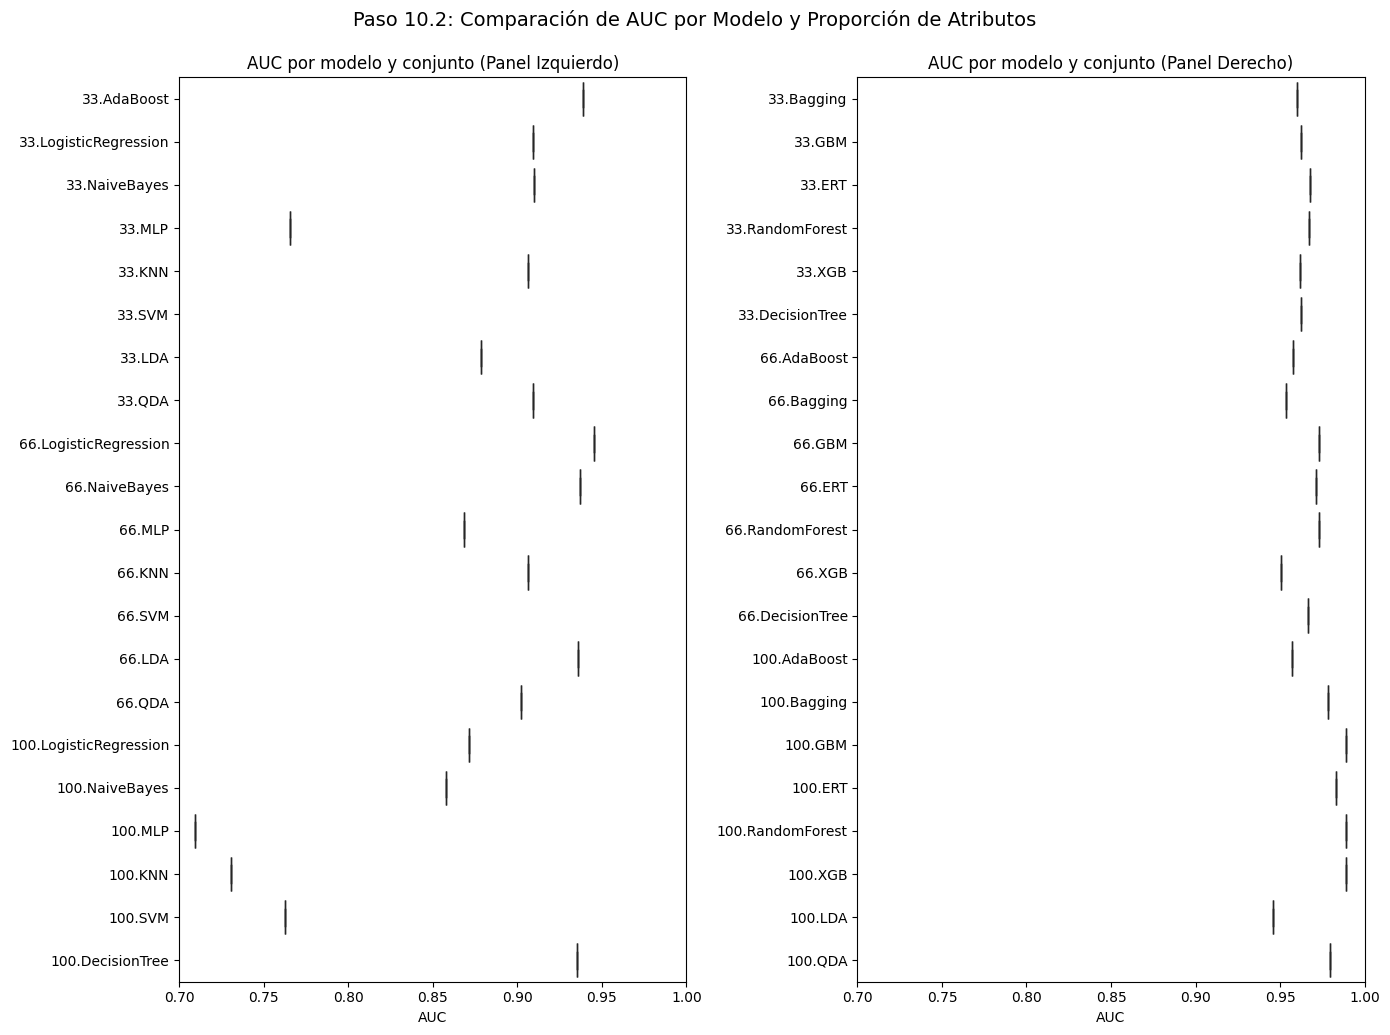

In [37]:
# Gráfico tipo panel para AUC tipo boxplot de los diferentes conjuntos de datos 
import matplotlib.gridspec as gridspec
#Paso 10.2: Visualización tipo panel con AUC por modelo y proporción de atributos

# Asegurarse de que las columnas 'Label' y 'Color' estén bien definidas
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['attr'].map({'33': 'red', '66': 'green', '100': 'blue'})

# Ordenar las etiquetas por AUC promedio
metric = 'AUC'
sorted_labels = df_results_all.groupby('Label')[metric].mean().sort_values().index

# Crear figura dividida en dos paneles
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

# Separar las etiquetas en dos mitades para dos paneles
half = len(sorted_labels) // 2

for i, ax in enumerate(axs):
    labels = sorted_labels[half*i:half*(i+1)]
    subset = df_results_all[df_results_all['Label'].isin(labels)]
    sns.boxplot(
        data=subset,
        y='Label',
        x=metric,
        hue='attr',
        orient='h',
        ax=ax,
        palette={'33': 'red', '66': 'green', '100': 'blue'}
    )
    ax.set_xlim(0.7, 1.0)
    ax.set_xlabel('AUC')
    ax.set_ylabel('')
    ax.set_title(f'AUC por modelo y conjunto ({"Panel Izquierdo" if i == 0 else "Panel Derecho"})')
    ax.legend_.remove()

plt.tight_layout()
plt.suptitle("Paso 10.2: Comparación de AUC por Modelo y Proporción de Atributos", fontsize=14, y=1.03)
plt.show()

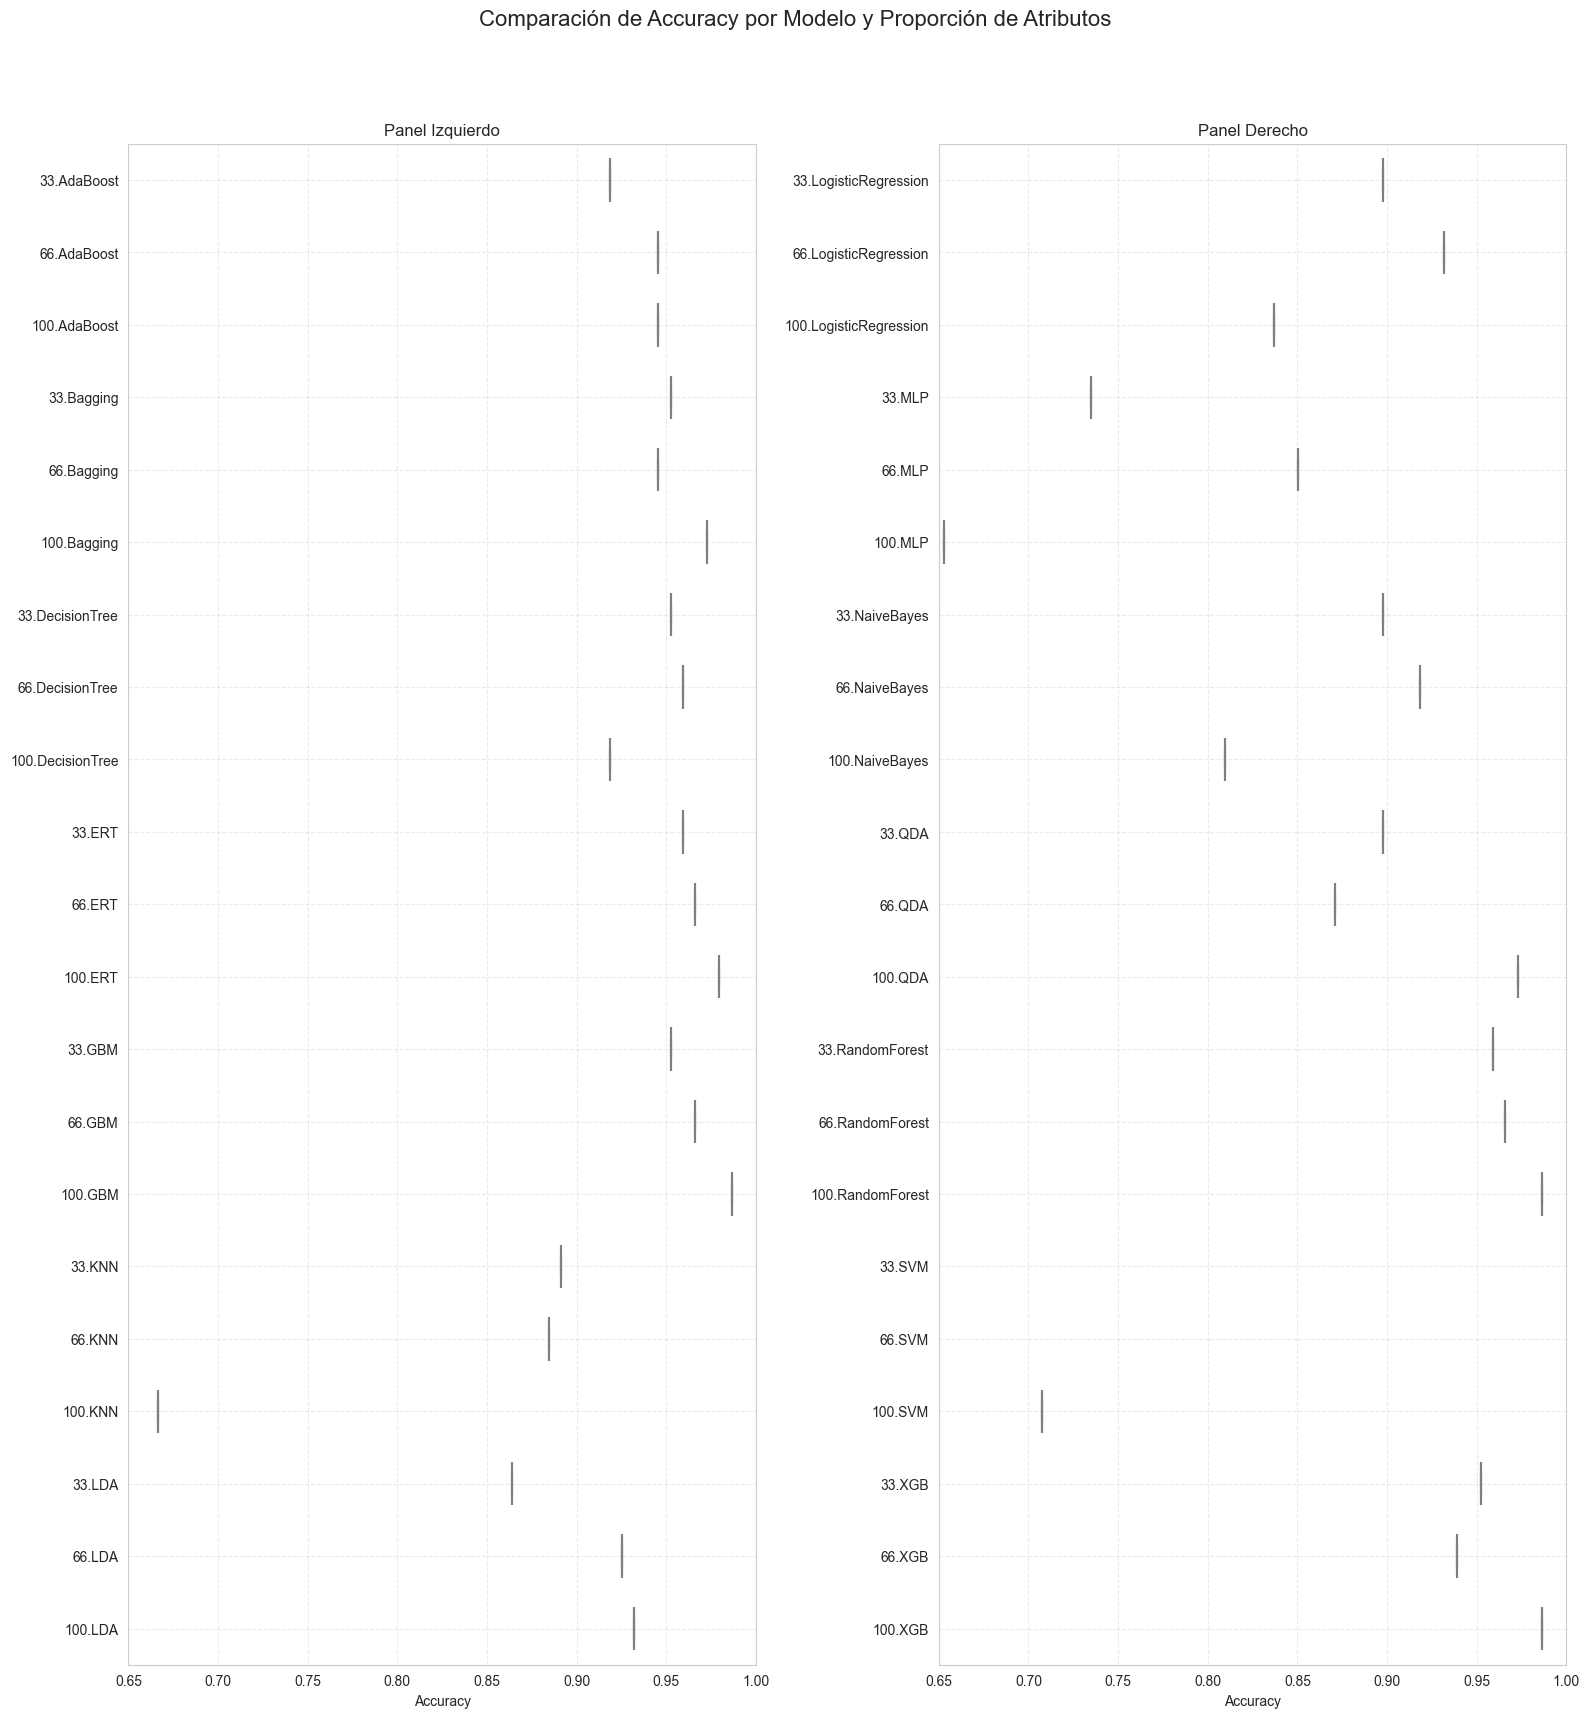

In [58]:
#Prueba de mejora de grafica 

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Preparar etiquetas combinadas y colores por grupo
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['attr'].map({
    '33': '#E41A1C',  # rojo
    '66': '#377EB8',  # azul
    '100': '#4DAF4A'  # verde
})
df_results_all.groupby('Label').size().sort_values()

# Ordenar etiquetas
sorted_labels = sorted(
    df_results_all['Label'].unique(),
    key=lambda x: (x.split('.')[1], int(x.split('.')[0]))
)

# Separar en 2 columnas
cols = 2
half = len(sorted_labels) // cols + len(sorted_labels) % cols
label_splits = [sorted_labels[:half], sorted_labels[half:]]

# Crear figura con buena altura
fig = plt.figure(figsize=(16, len(sorted_labels) * 0.4))
gs = gridspec.GridSpec(1, cols, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

# Pintar manualmente con color por caja
for i, ax in enumerate(axs):
    labels = label_splits[i]
    subset = df_results_all[df_results_all['Label'].isin(labels)]

    # Crear boxplot normal
    bplot = sns.boxplot(
        data=subset,
        x='Accuracy',
        y='Label',
        orient='h',
        order=labels,
        ax=ax,
        width=0.6,
        linewidth=1.5,
        fliersize=3,
        color='lightgray'  # temporal para sobrescribir después
    )

    # Reasignar color manual por caja
    for patch, label in zip(ax.artists, labels):
        color = df_results_all[df_results_all['Label'] == label]['Color'].iloc[0]
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)

    ax.set_xlim(0.65, 1.0)
    ax.set_xlabel("Accuracy")
    ax.set_ylabel("")
    ax.set_title("Panel Izquierdo" if i == 0 else "Panel Derecho")
    ax.grid(True, linestyle='--', alpha=0.4)

plt.suptitle("Comparación de Accuracy por Modelo y Proporción de Atributos", fontsize=16, y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()




In [38]:
# Análisis de Curvas de Rashomon con Múltiples Conjuntos de Atributos

import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import pandas as pd

warnings.filterwarnings('ignore')

# Supuestos: variables disponibles
# X, y, ranking_df, models

# Definición de subconjuntos de atributos
total_features = len(ranking_df)
feature_sets = {
    'top33': ranking_df.sort_values("Rank").head(round(0.33 * total_features)).index.tolist(),
    'top66': ranking_df.sort_values("Rank").head(round(0.66 * total_features)).index.tolist(),
    'top100': ranking_df.sort_values("Rank").index.tolist()
}

rashomon_results = []
epsilon = 0.01  # 1% del mejor AUC

for subset_name, features in feature_sets.items():
    X_sub = X[features]
    X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(X_sub, y, test_size=0.25, random_state=42)

    subset_scores = []
    best_auc = 0

    for model_label, model in models.items():
        try:
            start = time.time()
            model.fit(X_train_r, y_train_r)
            train_time = time.time() - start

            y_pred = model.predict(X_valid_r)
            try:
                y_prob = model.predict_proba(X_valid_r)
                if y_prob.shape[1] > 1:
                    from sklearn.preprocessing import label_binarize
                    y_bin = label_binarize(y_valid_r, classes=list(range(y_prob.shape[1])))
                    auc = roc_auc_score(y_bin, y_prob, average='macro')
                else:
                    auc = roc_auc_score(y_valid_r, y_prob[:, 0])
            except:
                auc = roc_auc_score(y_valid_r, y_pred)

            best_auc = max(best_auc, auc)

            if hasattr(model, 'n_estimators'):
                complexity = model.n_estimators
            elif hasattr(model, 'coef_'):
                complexity = model.coef_.shape[1]
            elif hasattr(model, 'hidden_layer_sizes'):
                complexity = sum(model.hidden_layer_sizes)
            elif hasattr(model, 'tree_'):
                complexity = model.tree_.max_depth
            elif hasattr(model, 'estimators_'):
                complexity = sum([est.tree_.node_count for est in model.estimators_])
            else:
                complexity = train_time

            subset_scores.append({
                'Subset': subset_name,
                'Model': model_label,
                'AUC': auc,
                'TrainingTime': train_time,
                'Complexity': complexity
            })
        except Exception as e:
            print(f'Error with {model_label} on {subset_name}:', e)

    rashomon_models = [s for s in subset_scores if s['AUC'] >= (best_auc - epsilon)]
    rashomon_volume = len(rashomon_models)

    for score in subset_scores:
        score['BestAUC'] = best_auc
        score['RashomonVolume'] = rashomon_volume
        score['WithinEpsilon'] = score['AUC'] >= (best_auc - epsilon)

    rashomon_results.extend(subset_scores)

rashomon_df = pd.DataFrame(rashomon_results)
rashomon_df

,Subset,Model,AUC,TrainingTime,Complexity,BestAUC,RashomonVolume,WithinEpsilon
0,top33,AdaBoost,0.981726,0.085757,50.000000,0.996510,5,False
1,top33,Bagging,0.990207,0.021354,10.000000,0.996510,5,True
2,top33,GBM,0.995930,0.438569,100.000000,0.996510,5,True
3,top33,ERT,0.996185,0.096808,100.000000,0.996510,5,True
4,top33,RandomForest,0.996510,0.126763,100.000000,0.996510,5,True
5,top33,XGB,0.995474,0.068537,NaN,0.996510,5,True
6,top33,LogisticRegression,0.978674,0.246975,9.000000,0.996510,5,False
7,top33,NaiveBayes,0.977786,0.000997,0.000997,0.996510,5,False
8,top33,MLP,0.921638,0.079517,100.000000,0.996510,5,False
9,top33,KNN,0.948644,0.001995,0.001995,0.996510,5,False


In [39]:

# Identificar modelos en el frente de Pareto (AUC vs. Complejidad)

def is_pareto_efficient(df, perf_col="AUC", cost_col="Complexity"):
    is_efficient = []
    for i, row_i in df.iterrows():
        dominated = False
        for j, row_j in df.iterrows():
            if (
                (row_j[perf_col] >= row_i[perf_col])
                and (row_j[cost_col] <= row_i[cost_col])
                and ((row_j[perf_col] > row_i[perf_col]) or (row_j[cost_col] < row_i[cost_col]))
            ):
                dominated = True
                break
        is_efficient.append(not dominated)
    return is_efficient

# Aplicar por subconjunto
pareto_df_list = []
for subset in rashomon_df['Subset'].unique():
    df_subset = rashomon_df[rashomon_df['Subset'] == subset].copy()
    df_subset['ParetoFront'] = is_pareto_efficient(df_subset)
    pareto_df_list.append(df_subset)

pareto_df = pd.concat(pareto_df_list)

# Exportar modelos en el frente de Pareto
pareto_df[pareto_df['ParetoFront']].to_csv("rashomon_pareto_models.csv", index=False)
print("Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'")
pareto_df[pareto_df['ParetoFront']]


Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'


,Subset,Model,AUC,TrainingTime,Complexity,BestAUC,RashomonVolume,WithinEpsilon,ParetoFront
1,top33,Bagging,0.990207,0.021354,10.000000,0.996510,5,True,True
4,top33,RandomForest,0.996510,0.126763,100.000000,0.996510,5,True,True
5,top33,XGB,0.995474,0.068537,NaN,0.996510,5,True,True
6,top33,LogisticRegression,0.978674,0.246975,9.000000,0.996510,5,False,True
7,top33,NaiveBayes,0.977786,0.000997,0.000997,0.996510,5,False,True
15,top66,Bagging,0.987762,0.026493,10.000000,0.999786,5,False,True
16,top66,GBM,0.998995,0.721910,100.000000,0.999786,5,True,True
19,top66,XGB,0.999786,0.089117,NaN,0.999786,5,True,True
21,top66,NaiveBayes,0.913542,0.000997,0.000997,0.999786,5,False,True
25,top66,DecisionTree,0.967993,0.002997,6.000000,0.999786,5,False,True


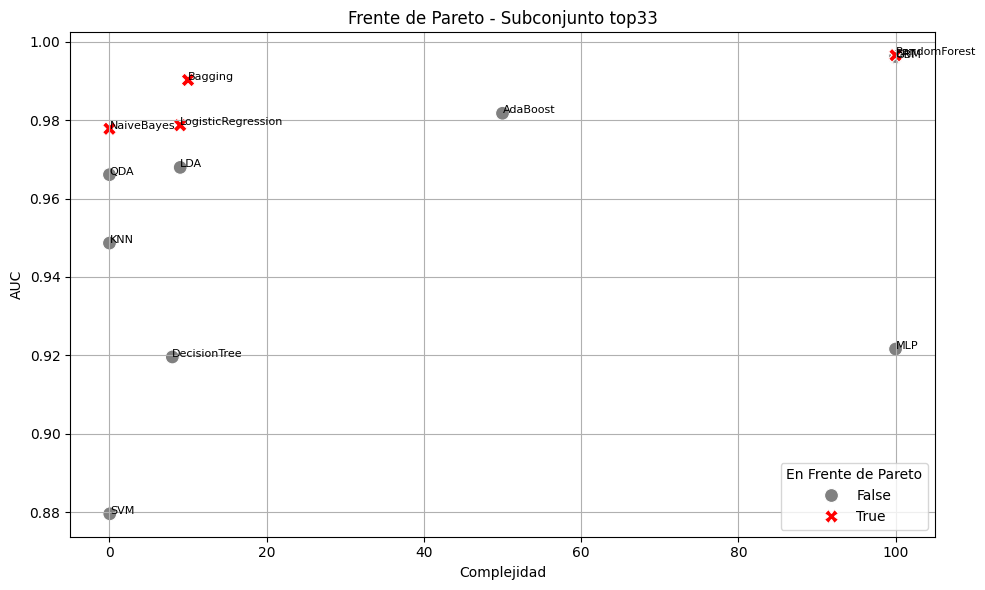

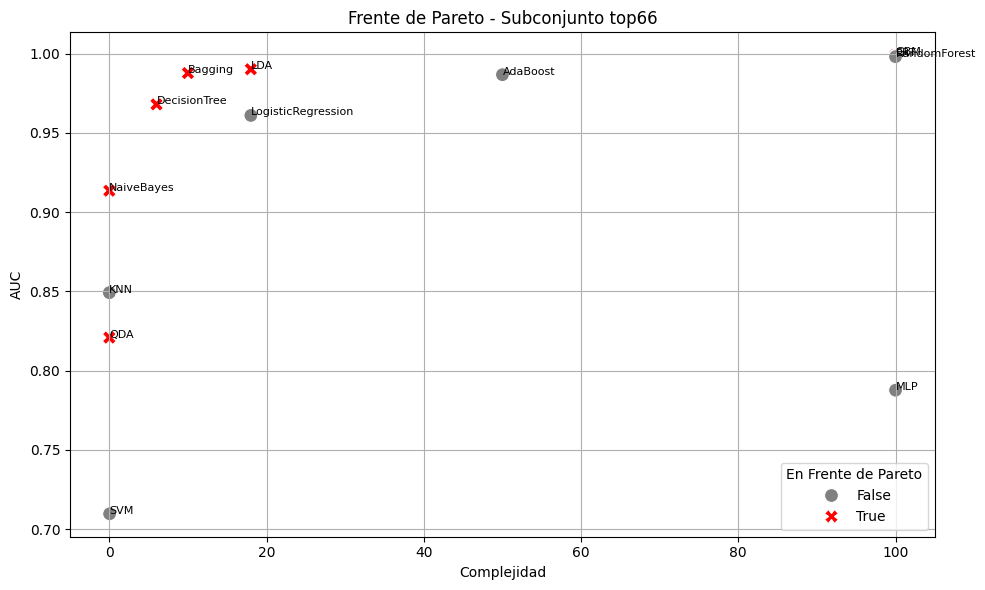

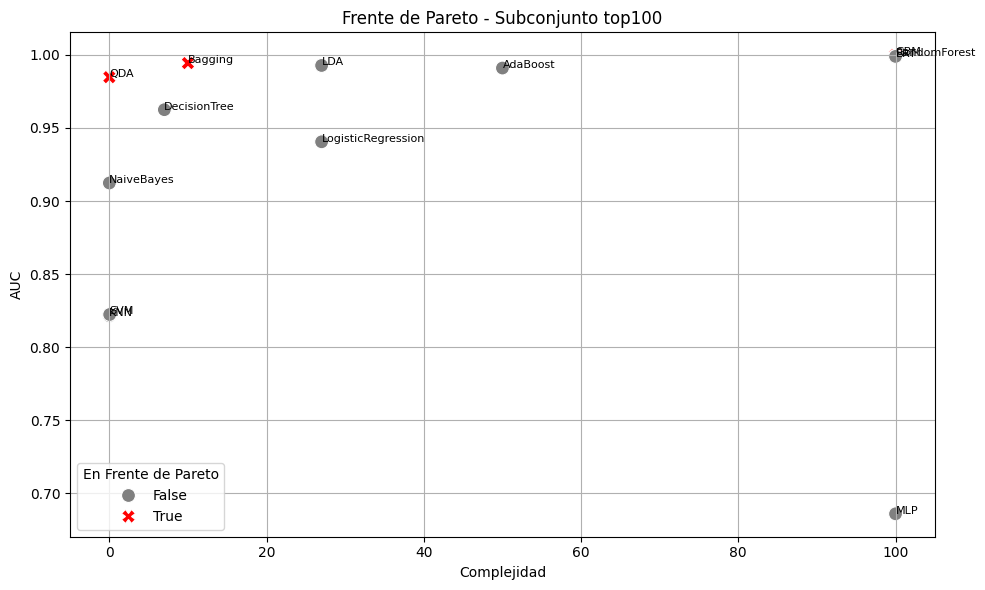

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualización del frente de Pareto para cada subconjunto
for subset in pareto_df['Subset'].unique():
    data = pareto_df[pareto_df['Subset'] == subset]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='Complexity', y='AUC',
        hue='ParetoFront',
        style='ParetoFront',
        palette={True: 'red', False: 'gray'},
        data=data,
        s=100
    )
    for _, row in data.iterrows():
        plt.text(row['Complexity'], row['AUC'], row['Model'], fontsize=8)

    plt.title(f'Frente de Pareto - Subconjunto {subset}')
    plt.xlabel('Complejidad')
    plt.ylabel('AUC')
    plt.legend(title='En Frente de Pareto')
    plt.grid(True)
    plt.tight_layout()
    plt.show()